# Using H2O Machine Learning and Kalman Filters for Machine Prognostics

# Import and initialize h2o

In [29]:
import h2o
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

//anaconda/envs/h2o-latest-py27/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
//anaconda/envs/h2o-latest-py27/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
//anaconda/envs/h2o-latest-py27/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
//anaconda/envs/h2o-latest-py27/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'c

In [2]:
h2o.init()



No instance found at ip and port: localhost:54321. Trying to start local jar...


JVM stdout: /var/folders/wg/3qx1qchx1jsfjqqbmz3stj7c0000gn/T/tmpq4cttu/h2o_hank_started_from_python.out
JVM stderr: /var/folders/wg/3qx1qchx1jsfjqqbmz3stj7c0000gn/T/tmpAG9ykL/h2o_hank_started_from_python.err
Using ice_root: /var/folders/wg/3qx1qchx1jsfjqqbmz3stj7c0000gn/T/tmpdFai8z


Java Version: java version "1.8.0_40"
Java(TM) SE Runtime Environment (build 1.8.0_40-b27)
Java HotSpot(TM) 64-Bit Server VM (build 25.40-b25, mixed mode)


Starting H2O JVM and connecting: ........................ Connection successful!


//anaconda/envs/h2o-latest-py27/lib/python2.7/site-packages/IPython/core/formatters.py:90: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
//anaconda/envs/h2o-latest-py27/lib/python2.7/site-packages/IPython/core/formatters.py:96: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
//anaconda/envs/h2o-latest-py27/lib/python2.7/site-packages/IPython/core/formatters.py:675: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
//anaconda/envs/h2o-latest-py27/lib/python2.7/site-packages/IPython/core/formatters.py:667: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):
//anaconda/envs/h2o-la

H2O cluster uptime:,2 seconds 653 milliseconds
H2O cluster version:,3.8.0.4
H2O cluster name:,H2O_started_from_python_hank_jbr469
H2O cluster total nodes:,1
H2O cluster total free memory:,3.56 GB
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321
H2O Connection proxy:,None


# Import the training and test sets, look at summary statistics

In [3]:
train = h2o.upload_file("train_FD004_processed.csv")
test  = h2o.upload_file("test_FD004_processed.csv")


Parse Progress: [##################################################] 100%

Parse Progress: [##################################################] 100%


# Define the names of the features
These are both the features in the original data file and some of the features that will be created later on.

In [4]:
# Setup the column names of the training file
index_columns_names =  ["UnitNumber","Cycle"]

weight_column = "Cycle"

# And the name of the to be engineered target variable
dependent_var = ['RemainingUsefulLife']

independent_vars = [column_name for column_name in train.columns if re.search("CountInMode|stdized_SensorMeasure", column_name)]
independent_vars

[u'CountInMode1',
 u'CountInMode0',
 u'CountInMode5',
 u'CountInMode4',
 u'CountInMode2',
 u'CountInMode3',
 u'stdized_SensorMeasure2',
 u'stdized_SensorMeasure3',
 u'stdized_SensorMeasure4',
 u'stdized_SensorMeasure6',
 u'stdized_SensorMeasure7',
 u'stdized_SensorMeasure8',
 u'stdized_SensorMeasure9',
 u'stdized_SensorMeasure10',
 u'stdized_SensorMeasure11',
 u'stdized_SensorMeasure12',
 u'stdized_SensorMeasure13',
 u'stdized_SensorMeasure14',
 u'stdized_SensorMeasure15',
 u'stdized_SensorMeasure17',
 u'stdized_SensorMeasure20',
 u'stdized_SensorMeasure21']

## Cross validation strategy
Use approximately 80% of the units for model building and cross validate with the other 20% of the units.  Use units as the information for the fold, not individual observations of the units.

In [5]:
fold_column_name = "FoldColumn"
train[fold_column_name] = train["UnitNumber"] % 5

## Build a H2O GBM Estimator, train the estimator, and review model results

In [6]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [9]:
gbm_regressor = H2OGradientBoostingEstimator(distribution="laplace", 
                                             score_each_iteration=True,
                                             stopping_metric="MSE", 
                                             stopping_tolerance=0.001,
                                             stopping_rounds=5,
                                             max_depth=10, ntrees=300)
gbm_regressor.train(x=independent_vars, y=dependent_var, 
                    training_frame=train, weights_column=weight_column,
                    fold_column=fold_column_name)


gbm Model Build Progress: [##################################################] 100%


In [10]:
gbm_regressor

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Method
Model Key:  GBM_model_python_1456252414214_8

Model Summary: 


,number_of_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,166.0,590233.0,10.0,10.0,10.0,86.0,629.0,302.0723




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1070.84726192
R^2: 0.818647124106
Mean Residual Deviance: 16.9290717449

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 1143.5872459
R^2: 0.806328275513
Mean Residual Deviance: 18.076473259

Scoring History: 


,timestamp,duration,number_of_trees,training_MSE,training_deviance
,2016-02-23 11:11:06,24 min 38.485 sec,0.0,6182.4618525,59.7451581
,2016-02-23 11:11:10,24 min 42.685 sec,1.0,5422.3766001,54.9015613
,2016-02-23 11:11:15,24 min 47.664 sec,2.0,4773.7105913,50.6092767
,2016-02-23 11:11:17,24 min 49.559 sec,3.0,4235.5205670,46.8769544
,2016-02-23 11:11:19,24 min 51.573 sec,4.0,3783.4904248,43.5608910
---,---,---,---,---,---
,2016-02-23 11:15:03,28 min 35.395 sec,162.0,1073.3492063,16.9773693
,2016-02-23 11:15:04,28 min 36.465 sec,163.0,1073.2769747,16.9759016
,2016-02-23 11:15:06,28 min 38.233 sec,164.0,1072.0568113,16.9524455
,2016-02-23 11:15:07,28 min 39.627 sec,165.0,1071.4833432,16.9411230



See the whole table with table.as_data_frame()

Variable Importances: 


variable,relative_importance,scaled_importance,percentage
stdized_SensorMeasure11,102608640.0000000,1.0,0.2517591
stdized_SensorMeasure14,31405408.0000000,0.3060698,0.0770559
CountInMode1,30830854.0000000,0.3004704,0.0756461
stdized_SensorMeasure13,21343802.0000000,0.2080117,0.0523688
CountInMode4,20709766.0000000,0.2018326,0.0508132
---,---,---,---
stdized_SensorMeasure7,7751859.5,0.0755478,0.0190199
stdized_SensorMeasure17,6539798.5,0.0637354,0.0160460
stdized_SensorMeasure20,5631693.5,0.0548852,0.0138178
stdized_SensorMeasure21,5406277.0,0.0526883,0.0132648



See the whole table with table.as_data_frame()


## Prediction on the test data
Using the best model from the grid search (using MSE)

There is previous version of the work that uses the final scoring to pick the best model, this was kept simple on purpose.

In [12]:
best_model = gbm_regressor

# Prediction post processing
Because these are linear dynamic systems, with the prior belief that after each operation the unit's remaining useful life decreases by one, a Kalman filter is used to post process and ensemble the data.

### Signal processing using Kalman smoothing filter
Kalman filters use the prior belief about the state of a system, and ensembles measurement of the next measured state and model of how the system evolves from prior state (physics!) to make an improved estimate of the current system state.  In the absense of having the 'physics' and knowledge about the sensors, here we estimate the parameters for the Kalman filter.  Kalman filters are like smoothers, but  use future state information in addition to prior state information.

A visual introduction to Kalman filters is available at http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/ .  A great hackers introduction to Kalman and Bayseian filters is at  https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python .

<img src="cycle.png">

The hypothesis is that the state of the systems under consideration evolves in this time series manner and that remaining useful life decreases by 1 each operation. 

H2O now has Discrete Cosine Transforms (DCT) so those can be applied to data at scale in a distributed, in memory environment:  https://0xdata.atlassian.net/browse/PUBDEV-1865.  Also, see SciPy's signal and interpolation packages.

(image courtesy of http://www.codeproject.com/Articles/865935/Object-Tracking-Kalman-Filter-with-Ease)

### Use the main model and each cross validated model to build an ensemble of predictions

In [70]:
def sensor_preds(frame):
    frame["predict"] = ((frame["predict"] < 0.).ifelse(0., frame["predict"]))[0]
    return frame

models_for_pred = [best_model]+best_model.xvals
preds = [ sensor_preds(model.predict(test)) for model in models_for_pred ]
index = test[["UnitNumber","Cycle"]]
for i,pred in enumerate(preds):
    if i == 0:  # special handling for first model
        predictions = index.cbind(preds[i])
    else:
        predictions = predictions.cbind(preds[i])

predictions_df = predictions.as_data_frame(use_pandas=True)

In [71]:
# state is represented as [RUL, -1]
n_dim_state=2
n_dim_obs=len(preds)
a_transition_matrix = np.array([[1,1],[0,1]]) # Dynamics take state of [RUL, -1] and transition to [RUL-1, -1]
r_observation_covariance = np.diag( [ model.mse() for model in models_for_pred ] )
h_observation_matrices = np.array([[1,0] for _ in models_for_pred])

In [72]:
import pykalman as pyk

final_ensembled_preds = {}
pred_cols = [ name for name in predictions_df.columns if "predict" in name]
for unit in predictions_df.UnitNumber.unique():
    preds_for_unit = predictions_df[ predictions_df.UnitNumber == unit ]
    observations = preds_for_unit.as_matrix(pred_cols)
    initial_state_mean = np.array( [np.mean(observations[0]),-1] )
    kf = pyk.KalmanFilter(transition_matrices=a_transition_matrix,\
                          initial_state_mean=initial_state_mean,\
                          observation_covariance=r_observation_covariance,\
                          observation_matrices=h_observation_matrices,\
                          n_dim_state=n_dim_state, n_dim_obs=n_dim_obs)
    mean,_ = kf.filter(observations)
    final_ensembled_preds[unit] = mean

In [73]:
final_preds = { k:final_ensembled_preds[k][-1][0] for k in final_ensembled_preds.keys() }

In [74]:
final_preds_df = pd.DataFrame.from_dict(final_preds,orient='index')
final_preds_df.columns = ['predicted']

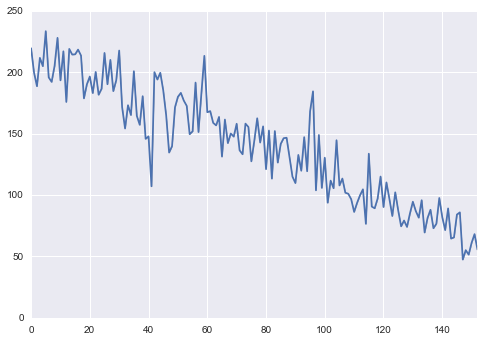

In [75]:
sns.tsplot(predictions_df[ predictions_df.UnitNumber == 2 ]["predict"])

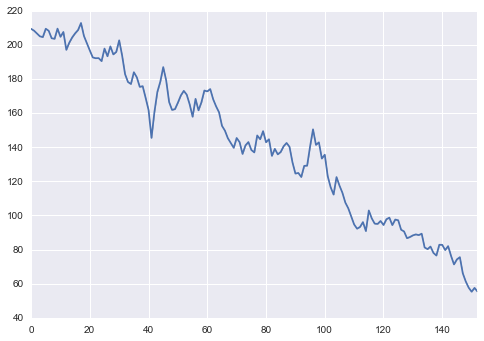

In [76]:
sns.tsplot(final_ensembled_preds[2].T[0])

## Do final scoring on the test data

In [77]:
actual_RUL = pd.read_csv("RUL_FD004.txt",header=None,names=["actual"])
actual_RUL.index = actual_RUL.index+1
actual_preds = actual_RUL.join(final_preds_df)

def score(x):
    diff = x.predicted-x.actual
    result = np.expm1(diff/-13.) if diff < 0. else np.expm1(diff/10.)
    return result

actual_preds["score"] = actual_preds.apply(score, axis=1)
sum(actual_preds.score)/len(actual_preds)

2542.2908657117891

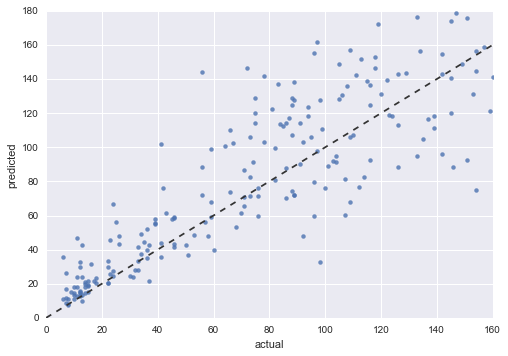

In [78]:
g = sns.regplot("actual", "predicted", data=actual_preds, fit_reg=False)
g.set(xlim=(0, 160), ylim=(0, 180));
g.axes.plot((0, 160), (0, 160), c=".2", ls="--");

In [ ]:
h2o.shutdown(prompt=False)